In [1]:
import random
import numpy as np
from deap import base, creator, tools, algorithms

In [2]:
class Tren:
    def __init__(self, numero_vagones, operacion, matricula):
        self.numero_vagones = numero_vagones
        self.operacion = operacion
        self.matricula = matricula

    def __str__(self):
        return "Número de vagones: " + str(self.numero_vagones) + "\n" + \
               "Muelle de operaciones: " + str(self.operacion) + "\n" + \
               "Matrícula: " + str(self.matricula)

In [3]:
def producir_lista_trenes_aleatoria(n, min_vagones, max_vagones):
    lista_trenes = []
    for i in range(n):        
        numero_vagones = random.randint(min_vagones, max_vagones)
        operacion = random.choice(["gas", "carbon", "contenedores"])
        lista_trenes.append(Tren(numero_vagones, operacion, i))
    return lista_trenes        

In [4]:
random.seed(1024)
lista_de_trenes = producir_lista_trenes_aleatoria(100, 5, 10)

In [5]:
print(lista_de_trenes[8])

Número de vagones: 6
Muelle de operaciones: carbon
Matrícula: 8


In [6]:
t = Tren(5, "gas", 12)

In [7]:
print(t)

Número de vagones: 5
Muelle de operaciones: gas
Matrícula: 12


In [8]:
def crear_cola_de_trenes(lista_de_trenes):
    auxiliar = lista_de_trenes
    random.shuffle(auxiliar)
    return auxiliar

In [9]:
class Cola_de_trenes(list):
    def __init__(self, lista_de_trenes):
        list.extend(self,crear_cola_de_trenes(lista_de_trenes))

    def __str__(self):
        cadena = ""
        for i in list(self):
            cadena += (str(i) + "\n")
        return cadena

In [10]:
cola_de_trenes = Cola_de_trenes(lista_de_trenes)

In [11]:
print(cola_de_trenes)

Número de vagones: 8
Muelle de operaciones: carbon
Matrícula: 94
Número de vagones: 6
Muelle de operaciones: contenedores
Matrícula: 73
Número de vagones: 10
Muelle de operaciones: contenedores
Matrícula: 7
Número de vagones: 7
Muelle de operaciones: carbon
Matrícula: 65
Número de vagones: 5
Muelle de operaciones: carbon
Matrícula: 25
Número de vagones: 6
Muelle de operaciones: gas
Matrícula: 74
Número de vagones: 8
Muelle de operaciones: carbon
Matrícula: 84
Número de vagones: 9
Muelle de operaciones: gas
Matrícula: 96
Número de vagones: 5
Muelle de operaciones: gas
Matrícula: 80
Número de vagones: 8
Muelle de operaciones: carbon
Matrícula: 22
Número de vagones: 9
Muelle de operaciones: gas
Matrícula: 97
Número de vagones: 6
Muelle de operaciones: carbon
Matrícula: 30
Número de vagones: 7
Muelle de operaciones: carbon
Matrícula: 78
Número de vagones: 6
Muelle de operaciones: carbon
Matrícula: 61
Número de vagones: 10
Muelle de operaciones: carbon
Matrícula: 5
Número de vagones: 10
Mue

## Función fitness

In [12]:
# Creamos la función que calcula el tiempo de espera y la penalización de un tren
# en un muelle de operaciones concreto para poder usarla en la función de evaluación
def evaluacion(individuo):
    contadores_operaciones = {"gas": 0, "carbon": 0, "contenedores": 0}
    tiempo = 0

    for tren in individuo:
        proxima_demora = tren.numero_vagones
        if contadores_operaciones[tren.operacion] == 0:
            contadores_operaciones[tren.operacion] = proxima_demora
        else:
            demora_actual = contadores_operaciones[tren.operacion]
            for k, v in contadores_operaciones.items():
                contadores_operaciones[k] = max(0, v - demora_actual)
            contadores_operaciones[tren.operacion] = proxima_demora
            tiempo += demora_actual

    tiempo += max(contadores_operaciones.values())
    return tiempo,


Esta función de evaluación asigna un valor de aptitud (fitness) a una secuencia de llegada de trenes en función del tiempo total de espera y la penalización en los muelles de operaciones.

## Función de mutación

In [13]:
# Creamos la función de mutación que intercambia dos elementos de la lista de trenes
def funcion_mutacion(individuo):
    # Seleccionamos de forma aleatoria las posiciones a cambiar
    indices = np.random.choice(len(individuo), 2, replace=False)
    indice1 = indices[0]
    indice2 = indices[1]
    
    # Intercambiamos las posiciones de los elementos para mutar el individuo
    individuo[indice1], individuo[indice2] = individuo[indice2], individuo[indice1]
    return individuo,


Selecciona de forma aleatoria dos posiciones distintas en la secuencia de llegada de trenes representada por el individuo. Esto se hace utilizando np.random.choice para elegir dos índices aleatorios sin reemplazo.

Intercambia los elementos en las posiciones seleccionadas. Es decir, el tren en el primer índice se mueve al segundo índice, y viceversa.

La función devuelve el individuo mutado, que ahora tiene los trenes en dos posiciones diferentes intercambiadas.

Esta función de mutación introduce variabilidad en la población de individuos al cambiar el orden de llegada de dos trenes en una secuencia.

## Función de cruce

In [14]:
# Creamos la función de cruce que intercambia dos subcadenas de la lista de trenes entre dos individuos diferentes
def funcion_cruce(individuo1, individuo2):
    indice = np.random.randint(len(individuo1))
    izquierda_individuo1 = individuo1[:indice]
    derecha_individuo1 = individuo1[indice:]
    izquierda_individuo2 = individuo2[:indice]
    derecha_individuo2 = individuo2[indice:]

    # Cruce del individuo 1
    diferencia1 = set(individuo1) - (set(izquierda_individuo1) | set(derecha_individuo2))
    nuevo_derecha_individuo1 = []
    for t in derecha_individuo2:
        if t not in izquierda_individuo1:
            nuevo_derecha_individuo1.append(t)
        else:
            nuevo_derecha_individuo1.append(diferencia1.pop())

    # Cruce del individuo 2, que es el inverso del individuo 1
    diferencia2 = set(individuo1) - (set(izquierda_individuo2) | set(derecha_individuo1))
    nuevo_derecha_individuo2 = []
    for t in derecha_individuo1:
        if t not in izquierda_individuo2:
            nuevo_derecha_individuo2.append(t)
        else:
            nuevo_derecha_individuo2.append(diferencia2.pop())

    # Creamos los nuevos individuos
    nuevo_individuo1 = izquierda_individuo1 + nuevo_derecha_individuo2
    nuevo_individuo2 = izquierda_individuo2 + nuevo_derecha_individuo1
    
    # Actualizamos los individuos
    individuo1[:] = nuevo_individuo1
    individuo2[:] = nuevo_individuo2
    return individuo1, individuo2


Esta función de cruce realiza una operación de intercambio entre dos individuos que involucra la reorganización de las secuencias de llegada de trenes.

## Implementación

In [15]:
# Creamos la clase de fitness y la clase de individuos que hereda de la clase de trenes y de la clase de fitness creadas anteriormente
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individuo", Cola_de_trenes, fitness=creator.FitnessMax)

# Creamos una función auxiliar para inicializar cada individuo con una lista de trenes aleatoria
def individuo_inicializador():
    lista_trenes = producir_lista_trenes_aleatoria(100, 5, 10)  # Puedes ajustar los parámetros según sea necesario
    return creator.Individuo(lista_trenes)

# Creamos la toolbox con las funciones de evaluación, mutación, cruce y selección;
# que serán usadas por el algoritmo genético para crear la población inicial y evolucionarla
toolbox = base.Toolbox()

toolbox.register("individuo", individuo_inicializador)
toolbox.register("poblacion", tools.initRepeat, list, toolbox.individuo)

toolbox.register("evaluate", evaluacion)  # Asegurarse de que el nombre coincide con el esperado por el algoritmo
toolbox.register("mutate", funcion_mutacion)
toolbox.register("mate", funcion_cruce)
toolbox.register("select", tools.selTournament, tournsize=3)

# Definimos la población inicial de 100 individuos
poblacion = toolbox.poblacion(n=100)

Las clases personalizadas "FitnessMax" y "Individual" se utilizan para definir la estructura de los individuos y la función de aptitud. Además, se registran funciones de evaluación, mutación, cruce y selección en el toolbox, y se crea una población inicial de 100 individuos que se utilizará como punto de partida para la evolución de la población en el algoritmo genético

## Hall of fame

In [16]:
# Creamos el hall of fame, que almacena los mejores individuos de cada generación, y las estadísticas
hof = tools.HallOfFame(4)

# Establecemos las estadísticas que queremos obtener de la población en cada generación (media, mínimo y máximo)
stats = tools.Statistics(lambda indiv: indiv.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# Ejecutamos el algoritmo genético
poblacion, logbook = algorithms.eaSimple(poblacion, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg   	min	max
0  	100   	412.03	368	492
1  	58    	397.06	368	436
2  	56    	386.12	368	403
3  	70    	378.33	355	406
4  	66    	372.02	355	390
5  	74    	368.12	355	384
6  	60    	363.82	354	370
7  	58    	359.56	347	377
8  	74    	356.02	346	373
9  	56    	353.33	346	369
10 	56    	350.94	345	365
11 	61    	348.41	345	366
12 	62    	347.16	342	360
13 	58    	345.71	329	357
14 	59    	344.12	329	359
15 	68    	341.93	329	356
16 	57    	338.64	329	358
17 	50    	334.55	325	355
18 	61    	330.47	321	351
19 	48    	328.23	321	346
20 	56    	325.5 	318	340
21 	50    	323.18	318	339
22 	62    	322.59	318	337
23 	61    	321.44	318	333
24 	58    	321.54	316	341
25 	69    	320.58	316	334
26 	65    	319.42	309	334
27 	70    	318.15	309	333
28 	53    	316.36	309	333
29 	55    	314.29	309	325
30 	60    	312.79	309	328
31 	61    	310.97	309	325
32 	64    	310.44	306	326
33 	64    	309.91	305	327
34 	61    	308.72	305	324
35 	53    	307.45	305	319
36 	68    	306.27	298	321
37 	60    	3

Ejecuta el algoritmo genético utilizando la configuración proporcionada y recopila estadísticas sobre la población en cada generación.

In [17]:
# Imprimimos los mejores individuos de cada generación y su fitness asociado
print("El mejor individuo es:")
for t in hof[0]:
    print(t, "\n")
print("\nCon un fitness de: %s" % hof[0].fitness)


El mejor individuo es:
Número de vagones: 5
Muelle de operaciones: contenedores
Matrícula: 12 

Número de vagones: 9
Muelle de operaciones: carbon
Matrícula: 48 

Número de vagones: 7
Muelle de operaciones: gas
Matrícula: 37 

Número de vagones: 9
Muelle de operaciones: gas
Matrícula: 70 

Número de vagones: 8
Muelle de operaciones: contenedores
Matrícula: 76 

Número de vagones: 6
Muelle de operaciones: carbon
Matrícula: 83 

Número de vagones: 6
Muelle de operaciones: carbon
Matrícula: 40 

Número de vagones: 9
Muelle de operaciones: contenedores
Matrícula: 58 

Número de vagones: 10
Muelle de operaciones: carbon
Matrícula: 95 

Número de vagones: 7
Muelle de operaciones: gas
Matrícula: 86 

Número de vagones: 9
Muelle de operaciones: gas
Matrícula: 46 

Número de vagones: 10
Muelle de operaciones: contenedores
Matrícula: 30 

Número de vagones: 8
Muelle de operaciones: gas
Matrícula: 25 

Número de vagones: 5
Muelle de operaciones: contenedores
Matrícula: 74 

Número de vagones: 7
M

Aquí se imprime la secuencia de llegada de trenes que representa la solución encontrada por el algoritmo genético, así como el valor de aptitud que corresponde al tiempo total de paso para esa solución. Esta secuencia de llegada de trenes es la que minimiza el tiempo de paso del conjunto de trenes, que da 269 como resultado o el tiempo mínimo total de paso de los trenes.

## Representación

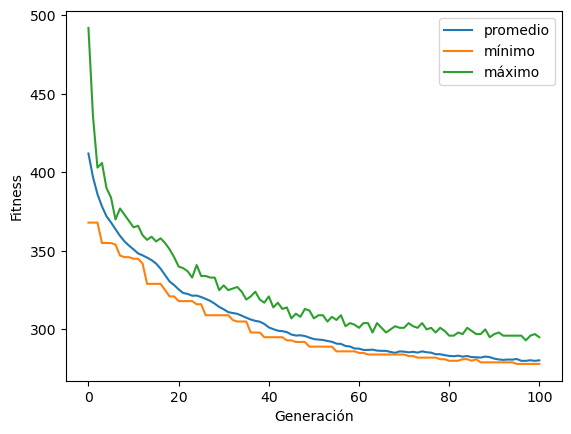

In [18]:
import matplotlib.pyplot as plt

# Mostramos los resultados en una gráfica de evolución de la media, el mínimo y el máximo de la población en cada generación
generaciones, promedio, minimo, maximo = logbook.select("gen", "avg", "min", "max")

plt.plot(generaciones, promedio, label="promedio")
plt.plot(generaciones, minimo, label="mínimo")
plt.plot(generaciones, maximo, label="máximo")
plt.xlabel("Generación")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()

In [19]:
#Vemos el fitness de los mejores individuos de cada generación
hof.keys

[deap.creator.FitnessMax((278.0,)),
 deap.creator.FitnessMax((278.0,)),
 deap.creator.FitnessMax((278.0,)),
 deap.creator.FitnessMax((278.0,))]

Para obtener una estimación del tiempo mínimo en una configuración ideal de trenes, calculamos el tiempo total asumiendo que cada tipo de operación no afecta a las demás. Sumamos los tiempos de cada operación por separado y luego seleccionamos el valor máximo entre estos tres tiempos resultantes. Este valor representará el tiempo mínimo que tardarían todos los trenes en pasar.

In [20]:
counters = {"gas": 0, "carbon": 0, "contenedores": 0}

for tren in lista_de_trenes:
    counters[tren.operacion] += tren.numero_vagones

print("Tiempo gas:", counters["gas"], "\nTiempo carbon:", counters["carbon"], "\nTiempo contenedores:", counters["contenedores"])

print("Por tanto, el tiempo mínimo será:", max(counters["gas"], counters["carbon"], counters["contenedores"]))
print("Y el tiempo calculado por el AG es de:", hof[0].fitness)


Tiempo gas: 244 
Tiempo carbon: 274 
Tiempo contenedores: 221
Por tanto, el tiempo mínimo será: 274
Y el tiempo calculado por el AG es de: (278.0,)


In [21]:
# Vemos el fitness de los mejores individuos de cada generación
for i, individuo in enumerate(hof):
    print(f"Mejor individuo de la generación {i}:")
    for tren in individuo:
        print(tren)
    print(f"Fitness: {individuo.fitness.values}\n")


Mejor individuo de la generación 0:
Número de vagones: 5
Muelle de operaciones: contenedores
Matrícula: 12
Número de vagones: 9
Muelle de operaciones: carbon
Matrícula: 48
Número de vagones: 7
Muelle de operaciones: gas
Matrícula: 37
Número de vagones: 9
Muelle de operaciones: gas
Matrícula: 70
Número de vagones: 8
Muelle de operaciones: contenedores
Matrícula: 76
Número de vagones: 6
Muelle de operaciones: carbon
Matrícula: 83
Número de vagones: 6
Muelle de operaciones: carbon
Matrícula: 40
Número de vagones: 9
Muelle de operaciones: contenedores
Matrícula: 58
Número de vagones: 10
Muelle de operaciones: carbon
Matrícula: 95
Número de vagones: 7
Muelle de operaciones: gas
Matrícula: 86
Número de vagones: 9
Muelle de operaciones: gas
Matrícula: 46
Número de vagones: 10
Muelle de operaciones: contenedores
Matrícula: 30
Número de vagones: 8
Muelle de operaciones: gas
Matrícula: 25
Número de vagones: 5
Muelle de operaciones: contenedores
Matrícula: 74
Número de vagones: 7
Muelle de operac

In [22]:
# Vemos el número de individuos que hay en el Hall of Fame
num_individuos_hof = len(set(hof[0]))
print(f"Número de individuos en el Hall of Fame: {num_individuos_hof}")


Número de individuos en el Hall of Fame: 100


# Comprobación de legalidad
Que no se repitan trenes y que estén todos los trenes que son. Es decir si hay 100 trenes distintos en la cola deben estar los 100 trenes distintos. No más pero tampoco menos. 

In [23]:
# Hacemos un set para ver el conjunto de matrículas de los trenes que hay en el Hall of Fame
matriculas = set()
for tren in hof[0]:
    matriculas.add(tren.matricula)

print(len(matriculas))  # debe darnos tantos como trenes tengan los individuos 
print(sorted(list(matriculas)))


100
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
